In [5]:
import os
import pandas as pd

# Función para extraer el nombre del modelo del nombre del archivo
def extract_model_name(filename):
    parts = filename.split('_')
    for part in parts:
        if part.startswith(('Llama', 'Yi', 'gemma', 'Mistral', 'GPT', 'phi')):
            return part
    return 'Unknown'

# Función para analizar los fallos en las preguntas y verificar en en_l0
def analyze_failures_with_en_l0(folder, priority_model="GPT"):
    question_failures = {}  # Diccionario para almacenar los fallos por pregunta
    model_columns = set()  # Conjunto para almacenar los nombres de los modelos (columnas dinámicas)
    
    # Primero procesar los archivos del modelo prioritario
    for filename in os.listdir(folder):
        if filename.startswith('paraphrases') and not filename.endswith('_copia.xlsx') and priority_model in filename:
            filepath = os.path.join(folder, filename)
            model_name = extract_model_name(filename)  # Extraer el nombre del modelo
            model_columns.add(model_name)  # Agregar el modelo a las columnas dinámicas
            
            print(f"Procesando primero el modelo prioritario: {model_name}")
            
            try:
                # Leer las hojas en_l1 y en_l0
                df_en_l1 = pd.read_excel(filepath, sheet_name='en_l1', engine='openpyxl')
                df_en_l0 = pd.read_excel(filepath, sheet_name='en_l0', engine='openpyxl')
                
                # Recorrer las filas del DataFrame en_l1
                for index, row in df_en_l1.iterrows():
                    question_id = index + 2  # Ajustar el índice para que coincida con la fila en Excel
                    question_text = row['question']
                    
                    # Inicializar la pregunta en el diccionario si no existe
                    if question_id not in question_failures:
                        question_failures[question_id] = {'question': question_text, 'failures': 0, 'acertadas': 0}
                    
                    # Verificar si la pregunta fue fallada en en_l1
                    if row['llm_answer_filtered'] != row['correct_answer']:
                        question_failures[question_id]['failures'] += 1
                    
                    # Verificar si la pregunta fue acertada o fallada en en_l0
                    en_l0_row = df_en_l0.iloc[index]  # Obtener la fila correspondiente en en_l0
                    if en_l0_row['llm_answer_filtered'] == en_l0_row['correct_answer']:
                        question_failures[question_id][model_name] = 'Acertada'
                        question_failures[question_id]['acertadas'] += 1
                    else:
                        question_failures[question_id][model_name] = 'Fallada'
            
            except Exception as e:
                print(f"Error procesando el archivo {filename}: {e}")
    
    # Luego procesar el resto de archivos
    for filename in os.listdir(folder):
        if filename.startswith('paraphrases') and not filename.endswith('_copia.xlsx') and priority_model not in filename:
            filepath = os.path.join(folder, filename)
            model_name = extract_model_name(filename)  # Extraer el nombre del modelo
            model_columns.add(model_name)  # Agregar el modelo a las columnas dinámicas
            
            try:
                # Leer las hojas en_l1 y en_l0
                df_en_l1 = pd.read_excel(filepath, sheet_name='en_l1', engine='openpyxl')
                df_en_l0 = pd.read_excel(filepath, sheet_name='en_l0', engine='openpyxl')
                
                # Recorrer las filas del DataFrame en_l1
                for index, row in df_en_l1.iterrows():
                    question_id = index + 2  # Ajustar el índice para que coincida con la fila en Excel
                    question_text = row['question']
                    
                    # Inicializar la pregunta en el diccionario si no existe
                    if question_id not in question_failures:
                        question_failures[question_id] = {'question': question_text, 'failures': 0, 'acertadas': 0}
                    
                    # Verificar si la pregunta fue fallada en en_l1
                    if row['llm_answer_filtered'] != row['correct_answer']:
                        question_failures[question_id]['failures'] += 1
                    
                    # Verificar si la pregunta fue acertada o fallada en en_l0
                    en_l0_row = df_en_l0.iloc[index]  # Obtener la fila correspondiente en en_l0
                    if en_l0_row['llm_answer_filtered'] == en_l0_row['correct_answer']:
                        question_failures[question_id][model_name] = 'Acertada'
                        question_failures[question_id]['acertadas'] += 1
                    else:
                        question_failures[question_id][model_name] = 'Fallada'
            
            except Exception as e:
                print(f"Error procesando el archivo {filename}: {e}")
    
    # Asegurar que todas las preguntas tengan columnas para todos los modelos
    for question_id in question_failures:
        for model in model_columns:
            if model not in question_failures[question_id]:
                question_failures[question_id][model] = 'No evaluada'
    
    return question_failures, model_columns

# Función para guardar los resultados en un archivo Excel
def save_failures_to_excel(failures, model_columns, output_excel):
    # Convertir el diccionario a un DataFrame
    failures_df = pd.DataFrame.from_dict(failures, orient='index')
    failures_df.index.name = 'id'
    failures_df.reset_index(inplace=True)
    
    # Ordenar primero por número de fallos (descendente) y luego por número de acertadas (descendente)
    failures_df = failures_df.sort_values(by=['failures', 'acertadas'], ascending=[False, False])
    
    # Eliminar la columna auxiliar antes de guardar
    failures_df.drop(columns=['acertadas'], inplace=True)
    
    # Reordenar las columnas para que los modelos aparezcan juntos
    cols_order = ['id', 'question', 'failures'] + sorted(list(model_columns))
    failures_df = failures_df[cols_order]
    
    # Guardar el resultado en un archivo Excel
    failures_df.to_excel(output_excel, index=False, engine='openpyxl')
    print(f"Archivo generado: {output_excel}")

# Ejemplo de uso
folder = 'MMLU'  # Carpeta con los archivos Excel
output_excel = 'preguntas_falladas_mmlu.xlsx'
priority_model = 'phi'  # Modelo que se analizará primero (puedes cambiarlo a "GPT-4o-mini" o la parte del nombre que coincida)

# Ejecutar el análisis
failures, model_columns = analyze_failures_with_en_l0(folder, priority_model)
save_failures_to_excel(failures, model_columns, output_excel)

Procesando primero el modelo prioritario: phi-4
Archivo generado: preguntas_falladas_mmlu.xlsx


In [6]:
import os
import pandas as pd

def extract_model_name(filename):
    parts = filename.split('_')
    for part in parts:
        if part.startswith(('Llama', 'Yi', 'gemma', 'Mistral', 'GPT', 'phi')):
            return part
    return 'Unknown'

def generate_detailed_excel(folder, question_ids, output_excel):
    all_questions = {}

    for filename in os.listdir(folder):
        if filename.startswith('paraphrases_') and filename.endswith('.xlsx'):
            filepath = os.path.join(folder, filename)
            model_name = extract_model_name(filename)

            try:
                df_en_l0 = pd.read_excel(filepath, sheet_name='en_l0', engine='openpyxl')
                df_en_l1 = pd.read_excel(filepath, sheet_name='en_l1', engine='openpyxl')

                for question_id in question_ids:
                    # Buscar la fila que corresponde al ID
                    found = False
                    
                    for index, row in df_en_l0.iterrows():
                        # El ID corresponde al índice + 2 (como se hace en analyze_failures_with_en_l0)
                        current_id = index + 2
                        
                        if current_id == question_id:
                            row_en_l0 = row
                            row_en_l1 = df_en_l1.iloc[index]  # Misma posición en en_l1
                            found = True
                            
                            data = {
                                'Modelo': [model_name],
                                'Pregunta Original': [row_en_l0['question']],
                                'Opciones Originales A': [row_en_l0['A']],
                                'Opciones Originales B': [row_en_l0['B']],
                                'Opciones Originales C': [row_en_l0['C']],
                                'Opciones Originales D': [row_en_l0['D']],
                                'Respuesta Original': [row_en_l0['llm_answer_filtered']],
                                'Pregunta Parafraseada': [row_en_l1['question']],
                                'Opciones Parafraseadas A': [row_en_l1['A']],
                                'Opciones Parafraseadas B': [row_en_l1['B']],
                                'Opciones Parafraseadas C': [row_en_l1['C']],
                                'Opciones Parafraseadas D': [row_en_l1['D']],
                                'Respuesta Parafraseada': [row_en_l1['llm_answer_filtered']],
                                'Respuesta Correcta': [row_en_l0['correct_answer']]
                            }

                            df_question = pd.DataFrame(data)

                            sheet_name = f"Pregunta_{question_id}"
                            if sheet_name not in all_questions:
                                all_questions[sheet_name] = []
                            all_questions[sheet_name].append(df_question)
                            break
                    
                    if not found:
                        print(f"Pregunta ID {question_id} no encontrada en {filename}")

            except Exception as e:
                print(f"Error procesando el archivo {filename}: {e}")

    with pd.ExcelWriter(output_excel, engine='openpyxl') as writer:
        for sheet_name, dfs in all_questions.items():
            combined_df = pd.concat(dfs, ignore_index=True)
            combined_df.to_excel(writer, sheet_name=sheet_name, index=False)

    print(f"Archivo generado: {output_excel}")

# Uso
folder = 'MMLU'
question_ids = [1568, 2734, 4114, 4743, 7489, 5006, 1024]  # ids que son los números de fila de Excel
output_excel = 'preguntas_seleccionadas.xlsx'

generate_detailed_excel(folder, question_ids, output_excel)


Archivo generado: preguntas_seleccionadas.xlsx


🚀 Iniciando análisis de incidencias...
🔍 Procesando archivo: /Users/sandra/Desktop/Universidad/TFG/Resultados/preguntas_seleccionadas_NM_V3.xlsx
📑 Hojas encontradas: 7
  ✅ Procesando hoja: Pregunta_1568
  ✅ Procesando hoja: Pregunta_2734
  ✅ Procesando hoja: Pregunta_4114
  ✅ Procesando hoja: Pregunta_4743
  ✅ Procesando hoja: Pregunta_7489
  ✅ Procesando hoja: Pregunta_5006
  ✅ Procesando hoja: Pregunta_1024


/var/folders/c2/7s13mf2d2v363_1g197xk9bm0000gn/T/ipykernel_68948/584705215.py:160: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  grafico = sns.barplot(


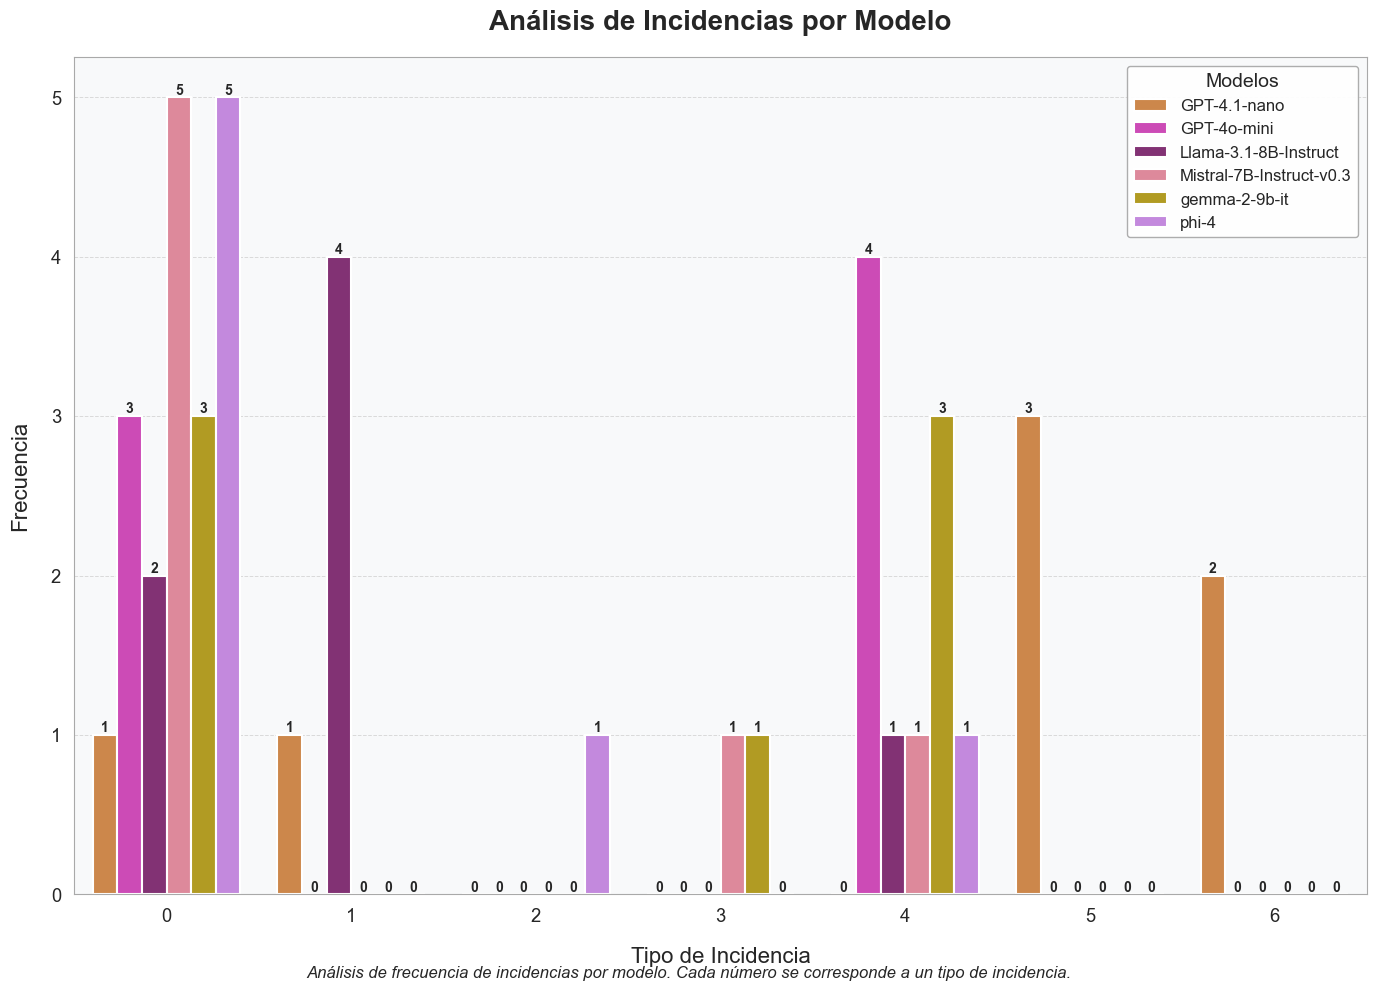

📊 Resumen guardado como: preguntas_seleccionadas_NM_V3_resumen_incidencias.xlsx
✅ Análisis completado con éxito!


/var/folders/c2/7s13mf2d2v363_1g197xk9bm0000gn/T/ipykernel_68948/584705215.py:220: FutureWarning: The default value of observed=False is deprecated and will change to observed=True in a future version of pandas. Specify observed=False to silence this warning and retain the current behavior
  tabla_pivot = pd.pivot_table(


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import numpy as np
from matplotlib.colors import LinearSegmentedColormap
from pathlib import Path

def analizar_incidencias_por_modelo(archivo_excel="/Users/sandra/Downloads/preguntas_seleccionadas_NM2.xlsx"):
    """
    Procesa un archivo Excel con múltiples hojas y extrae las incidencias por modelo.
    Genera un gráfico estético con la frecuencia de cada tipo de incidencia.
    
    Args:
        archivo_excel: Ruta al archivo Excel a procesar
    """
    # Configurar estilo visual moderno
    sns.set(style="whitegrid", font_scale=1.2)
    plt.rcParams['font.family'] = 'sans-serif'
    plt.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans', 'Liberation Sans']
    
    # Validar ruta del archivo
    archivo_excel = Path(archivo_excel)
    if not archivo_excel.is_file():
        print(f"⚠️ Error: El archivo '{archivo_excel}' no existe.")
        return None
    
    # Mensaje de inicio
    print(f"🔍 Procesando archivo: {archivo_excel}")
    
    # Cargar el archivo Excel
    xls = pd.ExcelFile(archivo_excel)
    hojas = xls.sheet_names
    print(f"📑 Hojas encontradas: {len(hojas)}")
    
    # Diccionario para almacenar datos por modelo
    datos_por_modelo = {}
    
    # Procesar cada hoja
    for hoja in hojas:
        try:
            df = pd.read_excel(archivo_excel, sheet_name=hoja)
            
            # Verificar columnas necesarias
            if 'Incidencia' not in df.columns:
                print(f"  ⏩ La hoja '{hoja}' no contiene la columna 'Incidencia'. Se omitirá.")
                continue
                
            if 'Modelo' not in df.columns:
                print(f"  ⏩ La hoja '{hoja}' no contiene la columna 'Modelo'. Se omitirá.")
                continue
                
            print(f"  ✅ Procesando hoja: {hoja}")
            
            # Procesar incidencias para cada modelo
            for _, fila in df.iterrows():
                modelo = fila['Modelo']
                incidencia = fila['Incidencia']
                
                # Ignorar filas con incidencias nulas
                if pd.isna(incidencia):
                    continue
                
                # Convertir a entero si es posible
                try:
                    incidencia = int(incidencia)
                except:
                    print(f"  ⚠️ Valor no numérico: '{incidencia}' para modelo {modelo}")
                    continue
                
                # Inicializar contador para el modelo si no existe
                if modelo not in datos_por_modelo:
                    datos_por_modelo[modelo] = {}
                
                # Incrementar contador de incidencia
                if incidencia not in datos_por_modelo[modelo]:
                    datos_por_modelo[modelo][incidencia] = 0
                datos_por_modelo[modelo][incidencia] += 1
                
        except Exception as e:
            print(f"  ❌ Error al procesar la hoja '{hoja}': {e}")
    
    # Verificar si se encontraron datos
    if not datos_por_modelo:
        print("❌ No se encontraron datos válidos en ninguna hoja.")
        return None
    
    # Crear un DataFrame para visualización
    filas = []
    for modelo, incidencias in datos_por_modelo.items():
        for incidencia, frecuencia in incidencias.items():
            filas.append({
                'Modelo': modelo,
                'Incidencia': incidencia,
                'Frecuencia': frecuencia
            })
    
    df_resultado = pd.DataFrame(filas)
    
    # Asegurar que existan valores de incidencia de 0 a 6 para todos los modelos (si faltan)
    todos_modelos = df_resultado['Modelo'].unique()
    todas_incidencias = range(0, 7)  # De 0 a 6
    
    filas_completas = []
    for modelo in todos_modelos:
        for incidencia in todas_incidencias:
            fila = df_resultado[(df_resultado['Modelo'] == modelo) & 
                              (df_resultado['Incidencia'] == incidencia)]
            if len(fila) == 0:
                filas_completas.append({
                    'Modelo': modelo,
                    'Incidencia': incidencia,
                    'Frecuencia': 0
                })
            else:
                filas_completas.append(fila.iloc[0].to_dict())
    
    df_completo = pd.DataFrame(filas_completas)
    
    # Crear un gráfico atractivo
    # Definir una paleta de colores personalizada y estética con tonos vibrantes
    colores = [
        "#E18636",  # Naranja vibrante
        "#E136C4",  # Rosa brillante
        "#8F257D",  # Magenta vibrante
        "#EB7B93",  # Rojo intenso
        "#C8AB0C",  # Amarillo vibrante
        "#C87BEB",  # Lila
        "#FF00FF",  # Magenta puro
        "#1ABC9C",  # Turquesa vibrante
        "#D35400",  # Naranja oscuro
        "#C70039"   # Rojo granate
    ]
    
    # Si hay más modelos que colores, generar colores adicionales
    if len(todos_modelos) > len(colores):
        cmap = LinearSegmentedColormap.from_list("custom_cmap", colores)
        colores = [cmap(i) for i in np.linspace(0, 1, len(todos_modelos))]
    
    # Crear figura y ejes con más espacio
    plt.figure(figsize=(14, 10))
    
    # Configurar el fondo
    ax = plt.gca()
    ax.set_facecolor('#f8f9fa')
    
    # Agregar un grid sutil solo para las líneas horizontales
    ax.yaxis.grid(True, linestyle='--', linewidth=0.7, alpha=0.7)
    ax.set_axisbelow(True)
    
    # Ordenar modelos alfabéticamente
    df_completo['Modelo'] = pd.Categorical(df_completo['Modelo'], 
                                        categories=sorted(todos_modelos),
                                        ordered=True)
    
    # Asegurar que 'Frecuencia' sea entero
    df_completo['Frecuencia'] = df_completo['Frecuencia'].astype(int)
    
    # Crear el gráfico de barras con espacio entre grupos
    grafico = sns.barplot(
        x='Incidencia',
        y='Frecuencia',
        hue='Modelo',
        data=df_completo,
        palette=colores,
        alpha=1.0,
        edgecolor='white',
        linewidth=1.5
    )
    
    # Añadir los valores encima de las barras (solo enteros)
    for container in grafico.containers:
        grafico.bar_label(container, fmt='%d', fontsize=10, fontweight='bold')
    
    # Mejorar los títulos y etiquetas
    plt.title('Análisis de Incidencias por Modelo', fontsize=20, pad=20, fontweight='bold')
    plt.xlabel('Tipo de Incidencia', fontsize=16, labelpad=15)
    plt.ylabel('Frecuencia', fontsize=16, labelpad=15)
    
    # Mejorar la leyenda
    plt.legend(
        title='Modelos',
        title_fontsize=14,
        fontsize=12,
        loc='upper right',
        frameon=True,
        framealpha=0.95,
        edgecolor='darkgray'
    )
    
    # Añadir bordes sutiles a la figura
    for spine in ax.spines.values():
        spine.set_visible(True)
        spine.set_color('darkgray')
        spine.set_linewidth(0.8)
    
    # Añadir un texto explicativo
    plt.figtext(
        0.5, 0.01,
        "Análisis de frecuencia de incidencias por modelo. Cada número se corresponde a un tipo de incidencia.",
        ha='center',
        fontsize=12,
        style='italic'
    )
    
    # Ajustar los límites del eje Y para que comience en 0
    ax.set_ylim(bottom=0)
    
    # Asegurar que solo se muestren valores enteros en el eje Y
    ax.yaxis.set_major_locator(plt.MaxNLocator(integer=True))
    
    # Mostrar el gráfico
    plt.tight_layout()
    plt.show()
    
    # También crear un Excel con los resultados tabulados
    nombre_excel = archivo_excel.stem + "_resumen_incidencias.xlsx"
    with pd.ExcelWriter(nombre_excel) as writer:
        # Una hoja con todos los datos
        tabla_pivot = pd.pivot_table(
            df_completo, 
            values='Frecuencia', 
            index=['Modelo'], 
            columns=['Incidencia'],
            fill_value=0
        ).astype(int)  # Asegurar que sean enteros
        
        # Añadir totales
        tabla_pivot['Total'] = tabla_pivot.sum(axis=1)
        tabla_pivot.loc['Total'] = tabla_pivot.sum(axis=0)
        
        # Estilo para Excel
        tabla_pivot.to_excel(writer, sheet_name='Resumen')
        
        # Una hoja con los datos detallados
        df_completo.to_excel(writer, sheet_name='Datos_detallados', index=False)
        
        # Una hoja por modelo
        for modelo in todos_modelos:
            df_modelo = df_completo[df_completo['Modelo'] == modelo]
            df_modelo.to_excel(writer, sheet_name=f'Modelo_{modelo[:29]}', index=False)
    
    print(f"📊 Resumen guardado como: {nombre_excel}")
    
    return df_completo


# Ejecutar el análisis directamente sobre el archivo de preguntas seleccionadas
if __name__ == "__main__":
    # Ruta del archivo incluida directamente en el código
    archivo_excel = "/Users/sandra/Desktop/Universidad/TFG/Resultados/preguntas_seleccionadas_NM_V3.xlsx"
    
    try:
        print("🚀 Iniciando análisis de incidencias...")
        df_resultado = analizar_incidencias_por_modelo(archivo_excel)
        print("✅ Análisis completado con éxito!")
    except Exception as e:
        print(f"❌ Error durante el análisis: {e}")